# Generating an Image Captions Dataset

Image captions are natural language descriptions of an image. Models like CLIP and DALL-E were trained on millions of image-caption pairs to enable them to take text as input for generating an image. This is called *text-to-image generation*, where a model learns to understand the relationship between text and visual elements. The process through which these models learn this semantic text-image relationship is called *text conditioning*.

### Generating Image Captions
If the data you are working with does not have text captions, you can generate them yourself using any image-to-text model. 

In this notebook, we'll explain step-by-step how to use the Google's PaliGemma model to generate image captions for a dataset of animal faces. The same technique can be applied on any dataset of images.

## 1. Get the data

First, we must download our chosen dataset.

In [1]:
# To use the files in the parent directory run this cell
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

len(dataset): 1500


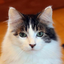

In [2]:
# Load raw image data
from src.datasets.hugging_face_dataset import HuggingFaceDataset

dataset_name = "zzsi/afhq64_16k"
dataset = HuggingFaceDataset(dataset_name, 'val')
print(f"len(dataset): {len(dataset)}")
dataset[0][0]

## 2. Get the model

Now, we can use HuggingFace to easily run inference on the PaliGemma model. 

In [3]:
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
import torch

model_id = "google/paligemma-3b-mix-224"
device = "cuda:0"
dtype = torch.bfloat16

model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=dtype,
    device_map=device,
    revision="bfloat16",
).eval().to(device)
processor = AutoProcessor.from_pretrained(model_id)


2025-01-13 14:33:39.573619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-13 14:33:39.648818: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 14:33:39.979174: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2025-01

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## 3. Generate a caption for a single image
Let's try to generate a caption for the first image. Since PaliGemma is takes an image an a text prompt, we can prompt is to output caption-like text by giving the prompt `"caption en <image>"` where the `<image>` will automatically get replaced by the input image.

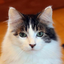

A white cat with black and brown spots looks directly at the camera. Its eyes are green and its nose is black. The cat's fur is white and its ears are white. The background is blurry.


In [4]:
# Display the image
image = dataset[0][0]
display(image)

# Setup the model inputs
prompt = "<image> caption en"
model_inputs = processor(text=prompt, images=image, return_tensors="pt").to(model.device)
input_len = model_inputs["input_ids"].shape[-1]

# Generate the caption
with torch.inference_mode():
    generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
    generation = generation[0][input_len:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(decoded)


## 4. Generating captions for the whole dataset

Here we only generate captions for the first 5 images so that this doesn't run for too long. Simply remove the first line.

In [5]:
dataset = list(dataset)[:5] # only process the first 5 images

# Generate captions for each image
captions = []
for data in dataset:
    image = data[0]
    prompt = "<image> caption en"
    model_inputs = processor(text=prompt, images=image, return_tensors="pt").to(model.device)
    input_len = model_inputs["input_ids"].shape[-1]

    with torch.inference_mode():
        generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
        generation = generation[0][input_len:]
        decoded = processor.decode(generation, skip_special_tokens=True)
        captions.append(decoded)
        print(decoded)

A white cat with black and brown spots looks directly at the camera. Its eyes are green and its nose is black. The cat's fur is white and its ears are white. The background is blurry.
A close-up of a brown and black cat with green eyes. The cat has a pink nose, white whiskers, and a brown and black coat. The background is blurry. The cat's eyes are green, and its ears are pointy. The cat is looking at the camera.
A white cat with two different colored eyes, one blue and one yellow, looks directly at the camera. Its eyes are blue on one side and yellow on the other. The cat has a pink nose, white whiskers, and a white chest. Its ears are pink and its fur is white. The cat is standing in front of a white background.
A calico cat with a white chest and green eyes looks directly at the camera. Its ears are perked up and its whiskers are long. The cat's eyes are blue and its nose is pink. The cat is standing on a blue surface and its fur is black and white.
A gray cat with yellow eyes looks

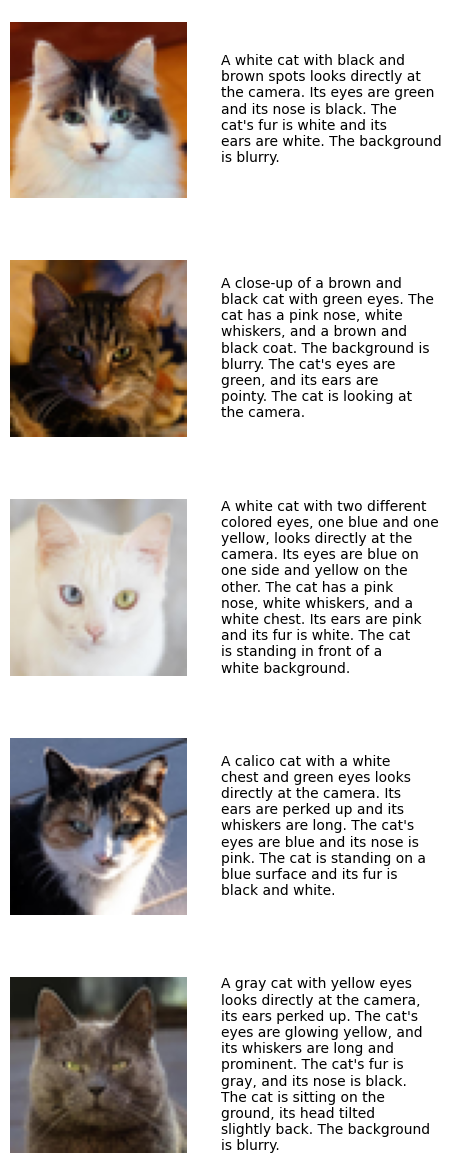

In [9]:

# Plot images with captions
import matplotlib.pyplot as plt
import textwrap

fig, axs = plt.subplots(len(dataset), 2, figsize=(5, 15))

for i in range(len(dataset)):
    axs[i, 0].imshow(dataset[i][0])
    axs[i, 0].axis('off')
    caption = textwrap.fill(captions[i], 30)
    axs[i, 1].text(0.0, 0.5, caption, verticalalignment='center', wrap=True)
    axs[i, 1].axis('off')


# 

## 5. Write to a json file

With the captions all generated, the only thing left to is to write them to a json for future use.

In [7]:
import json

# Save the captions to a JSON file
with open("captions.json", "w") as f:
    json.dump(captions, f)